## Internet access' potential to improve climate readiness in least developed countries

Reducing carbon emisions is key in our global climate mitigation efforts, but in the short-term we also need to adapt to a world where our changing climate poses a threat to life and wellbeing on Earth, especially for least developed countries. As will be shown, these countries have the least access to internet and therefore the least access to information and data, which hinders their ability to detect changes in their environment and adapt to the inevitable changes coming their way. We will focus specifically on the projected threat of water scarcity and extreme flooding that results from climate extremes in those countries. The datasets that will be used in the analysis are:

1. Internet Access by country- World Bank: https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS
2. GAIN index (Climate Vulnerability/ Readiness)- University of Notre Dame: https://gain.nd.edu/our-work/country-index/methodology/sectors/
3. % of population with access to reliable water sources- World Bank: https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS
4. Water stress ratio, freshwater withdrawal as a propotion of freshwater resources- FAO (Food and Agriculture Organization) UN: https://www.fao.org/aquastat/statistics/query/index.html;jsessionid=0BC93E2BDCF4AC53C26476EDC0390C10

## Data Import & Cleaning

In [1]:
#Necessary imports

import numpy as np
import pandas as pd
import geemap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing data in, adding suffix at the end of each column name for ease of use

df_country = pd.read_csv('Internet_Access.csv')
col_list = [col for col in df_country.columns if col.startswith(('196', '197', '198'))]
df_country = df_country.drop(col_list, axis = 1).add_suffix('_internet')

df_meta = pd.read_csv('Country_Metadata.csv').add_suffix('_meta')
df_gain = pd.read_csv('resources/gain/gain.csv').add_suffix('_GAIN')
df_water_access = pd.read_csv('Water_Access/Water_Access.csv').add_suffix('_access')

In [3]:
#Importing data for Water Stress Ratio and cleaning.

df_water_stress = pd.read_csv('Water_Stress_years.csv') #Read file in
df_water_stress.drop(range(1, len(df_water_stress), 3), inplace = True) #drop unnecessary blank rows
df_water_stress.drop(range(2, len(df_water_stress), 3), inplace = True)

col_list_drop = [col for col in df_water_stress.columns if col.startswith('Unnamed')] #drop unnecessary blank columns
df_water_stress.drop(columns = col_list_drop, inplace = True)


#Building separate columns for separate years based on year range in current columns
col_list = [col for col in df_water_stress.iloc[:, 1:].columns]

for i in col_list:
    for j in range(int(i[:4])+1, int(i[5:9])+1):
        df_water_stress[j] = df_water_stress[i]

#Renaming original columns to just one year instead of a range, adding suffix for ease of use, converting values
#from objects to numbers
renamed = [col[:4] for col in col_list]

df_water_stress.rename(columns = {col_list[i]: renamed[i] for i in range(len(renamed))}, inplace = True)
df_water_stress = df_water_stress.add_suffix('_stress')
df_water_stress_t = df_water_stress.iloc[:, 1:].apply(lambda col: pd.to_numeric(col, errors='coerce'), axis = 1)
df_water_stress = pd.concat([df_water_stress['Country_stress'], df_water_stress_t], axis = 1)

In [4]:
#Resultant dataframe for water stress

#Re-arrange columns
df_water_stress = df_water_stress[['Country_stress', '1993_stress', '1994_stress', '1995_stress','1996_stress','1997_stress', '1998_stress',
                                  '1999_stress', '2000_stress', '2001_stress', '2002_stress', '2003_stress','2004_stress',
                                  '2005_stress', '2006_stress', '2007_stress', '2008_stress', '2009_stress', '2010_stress',
                                  '2011_stress', '2012_stress', '2013_stress', '2014_stress', '2015_stress', '2016_stress',
                                  '2017_stress', '2018_stress', '2019_stress', '2020_stress', '2021_stress', '2022_stress']]

#Reset index, drop previous index
df_water_stress = df_water_stress.reset_index().drop('index', axis =1)
df_water_stress.head()

,Country_stress,1993_stress,1994_stress,1995_stress,1996_stress,1997_stress,1998_stress,1999_stress,2000_stress,2001_stress,...,2013_stress,2014_stress,2015_stress,2016_stress,2017_stress,2018_stress,2019_stress,2020_stress,2021_stress,2022_stress
0,Afghanistan,56.181246,56.181246,56.181246,56.181246,56.181246,54.757019,54.757019,54.757019,54.757019,...,54.757019,54.757019,54.757019,54.757019,54.757019,54.757019,54.757019,54.757019,54.757019,54.757019
1,Albania,8.596514,8.596514,8.596514,8.596514,8.596514,9.994712,9.994712,9.994712,9.994712,...,6.556490,6.556490,6.556490,6.556490,6.556490,5.757212,5.757212,5.757212,5.757212,5.757212
2,Algeria,74.208015,74.208015,74.208015,74.208015,74.208015,85.037372,85.037372,85.037372,85.037372,...,137.920360,137.920360,137.920360,137.920360,137.920360,137.920360,137.920360,137.920360,137.920360,137.920360
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,1.600490,1.600490,1.600490,1.600490,1.600490,1.767958,1.767958,1.767958,1.767958,...,1.871883,1.871883,1.871883,1.871883,1.871883,1.871883,1.871883,1.871883,1.871883,1.871883


In [5]:
#Correcting country names to match with other datasets for CRI and water stress dataframes, since they lack a country
#code
df_water_stress.replace({'Bolivia (Plurinational State of': 'Bolivia', "Côte d'Ivoire": "Cote d'Ivoire", 
                        'Congo': 'Congo, Rep.', "Democratic People's Republic of Korea": "Korea, Dem. People's Rep.",
                        'Egypt': 'Egypt, Arab Rep.', 'Gambia': 'Gambia, The', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
                        "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Korea': 'Korea, Rep.',
                        'Republic of Moldova': 'Moldova', 'Saint Kitts and Nevis': 'St. Kitts and Nevis',
                        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
                        'Saint Lucia': 'St. Lucia', 'Turkey': 'Turkiye', 'United Republic of Tanzania': 'Tanzania',
                         'United States of America': 'United States',
                        'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Viet Nam': 'Vietnam',
                        'Yemen': 'Yemen, Rep.'}, inplace = True)

In [6]:
#join all datasets to prepare for grouping by region

df_joined= (df_country.merge(df_meta, how = 'inner', left_on = 'Country Code_internet', right_on = 'Country Code_meta')
            #.merge(df_CRI, how = 'left', left_on = 'Country Name_internet', right_on = 'Country_CRI')
            .merge(df_gain, how = 'left', left_on = 'Country Code_internet', right_on = 'ISO3_GAIN')
            #.merge(df_water_depend, how = 'left', left_on = 'ISO3_GAIN', right_on = 'ISO3_depend')
            .merge(df_water_access, how = 'left', left_on = 'Country Code_internet', right_on = 'Country Code_access')
           .merge(df_water_stress, how = 'left', left_on = 'Country Name_internet', right_on = 'Country_stress'))

In [7]:
#Group by region

df_grouped = df_joined.groupby('Region_meta').mean()
df_grouped.reset_index(inplace = True)
df_grouped.head()

,Region_meta,1990_internet,1991_internet,1992_internet,1993_internet,1994_internet,1995_internet,1996_internet,1997_internet,1998_internet,...,2013_stress,2014_stress,2015_stress,2016_stress,2017_stress,2018_stress,2019_stress,2020_stress,2021_stress,2022_stress
0,East Asia & Pacific,0.016991,0.039629,0.096543,0.145969,0.297863,0.501567,1.525050,3.101293,5.258625,...,21.899386,21.899386,21.899386,21.899386,21.899386,21.865280,21.865280,21.865280,21.865280,21.865280
1,Europe & Central Asia,0.059392,0.141414,0.250980,0.384682,0.744733,1.443679,2.936958,5.032735,7.792387,...,24.639224,24.639224,24.639224,24.639224,24.639224,25.241176,25.241176,25.241176,25.241176,25.241176
2,Latin America & Caribbean,0.000000,0.000235,0.002259,0.007554,0.047172,0.344382,0.701696,1.051697,1.833781,...,14.572837,14.572837,14.572837,14.572837,14.572837,14.959226,14.959226,14.959226,14.959226,14.959226
3,Middle East & North Africa,0.005275,0.010220,0.014789,0.023376,0.035174,0.103413,0.365574,1.177548,2.177732,...,457.780045,457.780045,457.780045,457.780045,457.780045,460.555420,460.555420,460.555420,460.555420,460.555420
4,North America,0.381909,0.577860,0.880061,1.152077,2.413825,6.746259,13.127353,20.292672,29.031452,...,15.914154,15.914154,15.914154,15.914154,15.914154,15.914154,15.914154,15.914154,15.914154,15.914154


## Data Visualization

Visualizing timeseries data for internet access, GAIN index, water stress ratio, and % of population with access to water.

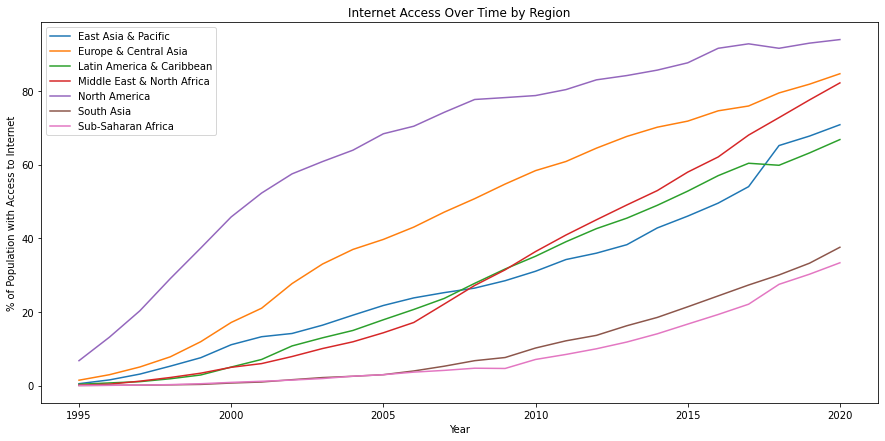

In [8]:
#Building out timeseries data and plotting by global region to visualize change over time for internet access

col_list = [col for col in df_grouped.columns if col.endswith('_internet')]
renamed = [int(col[:4]) for col in col_list]
region_list = df_grouped['Region_meta'].values.tolist()

fig = plt.figure(figsize = (15,7))

df_corr_i = pd.DataFrame()
for r in region_list:
    df_plot_i = df_grouped.loc[df_grouped['Region_meta'] == r][col_list].transpose()
    df_plot_i.rename(index = {col_list[i]: renamed[i] for i in range(len(renamed))}, inplace = True)
    df_plot_i.sort_index(inplace = True)
    df_plot_i = df_plot_i.loc[1995: 2020, :]
    df_corr_i[r] = df_plot_i.iloc[:,0].tolist()
    plt.plot(df_plot_i)

plt.legend(region_list)
plt.title('Internet Access Over Time by Region')
plt.xlabel('Year')
plt.ylabel('% of Population with Access to Internet')
plt.show()

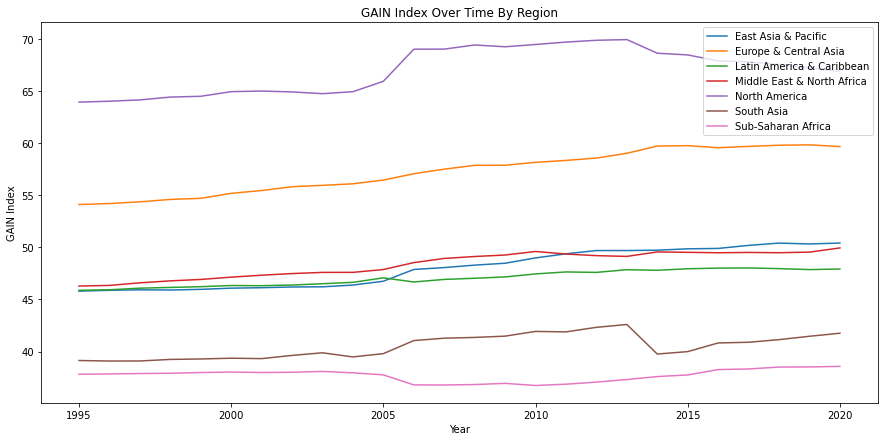

In [9]:
#Building out timeseries data and plotting by global region to visualize change over time for GAIN Index



col_list = [col for col in df_grouped.columns if col.endswith('_GAIN')]
renamed = [int(col[:4]) for col in col_list]

fig = plt.figure(figsize = (15,7))

df_corr_g = pd.DataFrame()
for r in region_list:
    df_plot_g = df_grouped.loc[df_grouped['Region_meta'] == r][col_list].transpose()
    df_plot_g.rename(index = {col_list[i]: renamed[i] for i in range(len(renamed))}, inplace = True)
    df_plot_g.sort_index(inplace = True)
    df_plot_g = df_plot_g.loc[1995: 2020, :] #filtering by the period of 1995- 2020, common between all datasets
    df_corr_g[r] = df_plot_g.iloc[:,0].tolist()
    plt.plot(df_plot_g)

plt.legend(region_list)
plt.title('GAIN Index Over Time By Region')
plt.xlabel('Year')
plt.ylabel('GAIN Index')
plt.show()

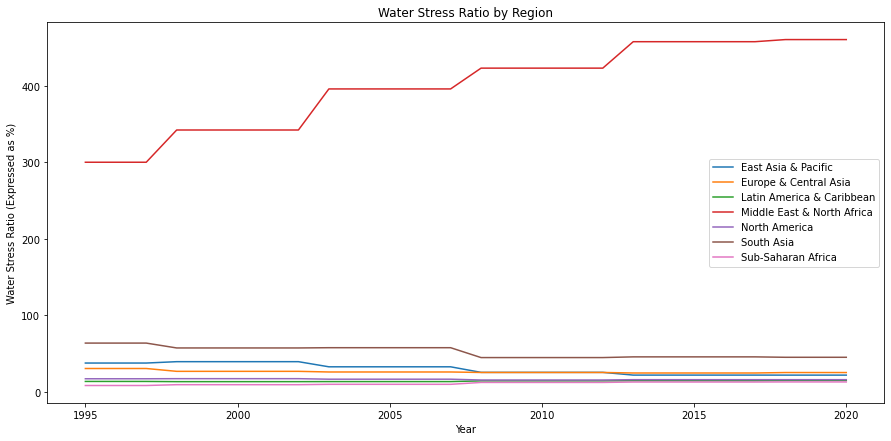

In [10]:
#Building out timeseries data and plotting by global region to visualize change over time for Water Stress
#Water Stress = Ratio between total freshwater withdrawn by all major sectors and total renewable freshwater resources

col_list = [col for col in df_grouped.columns if col.endswith('_stress')]
renamed = [int(col[:4]) for col in col_list]

fig = plt.figure(figsize = (15,7))

df_corr_s = pd.DataFrame()
for r in region_list:
    df_plot_s = df_grouped.loc[df_grouped['Region_meta'] == r][col_list].transpose()
    df_plot_s.rename(index = {col_list[i]: renamed[i] for i in range(len(renamed))}, inplace = True)
    df_plot_s.sort_index(inplace = True)
    df_plot_s = df_plot_s.loc[1995: 2020, :]
    df_corr_s[r] = df_plot_s.iloc[:,0].tolist()
    plt.plot(df_plot_s)

plt.legend(region_list)
plt.title('Water Stress Ratio by Region')
plt.xlabel('Year')
plt.ylabel('Water Stress Ratio (Expressed as %)')
plt.show()

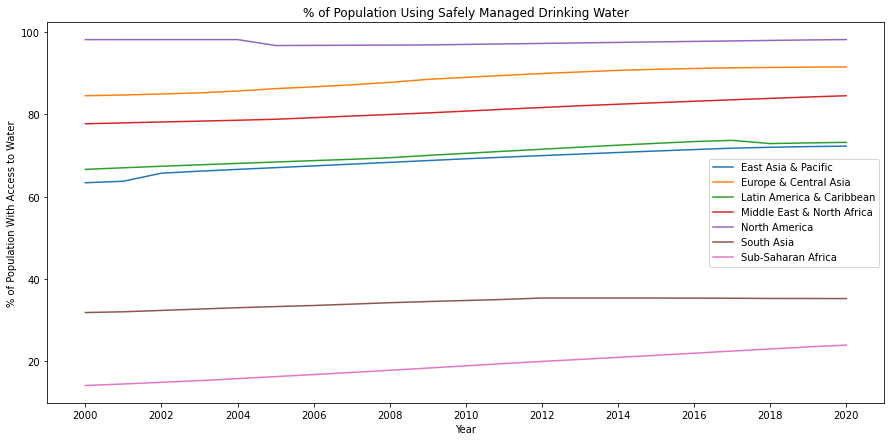

In [11]:
#Building out timeseries data and plotting by global region to visualize change over time for Access to Water

col_list = [col for col in df_grouped.columns if col.endswith('_access')]
renamed = [int(col[:4]) for col in col_list]

fig = plt.figure(figsize = (15,7))

df_corr_a = pd.DataFrame()
for r in region_list:
    df_plot_a = df_grouped.loc[df_grouped['Region_meta'] == r][col_list].transpose()
    df_plot_a.rename(index = {col_list[i]: renamed[i] for i in range(len(renamed))}, inplace = True)
    df_plot_a.sort_index(inplace = True)
    df_plot_a = df_plot_a.loc[1995: 2020, :]
    df_corr_a[r] = df_plot_a.iloc[:,0].tolist()
    plt.plot(df_plot_a)

plt.legend(region_list)
plt.title('% of Population Using Safely Managed Drinking Water')
plt.xlabel('Year')
plt.ylabel('% of Population With Access to Water')

x_ticks = range(2000, 2021, 2)
plt.xticks(x_ticks)

plt.show()

Internet access has made great strides in the last ~20 years, but GAIN (Vulernability/ Readiness for Climate Change), and access to water/ water stress have lagged. This shows that there is major potential to improve climate readiness/ vulnerability through increased internet access and IoT projects.

In [12]:
import seaborn as sb

In [13]:
#Rename columns of plot dataframes to differentiate between the columns
df_plot_g.rename(columns = {6: 'GAIN'}, inplace = True)
df_plot_s.rename(columns = {6: 'Stress'}, inplace = True)
df_plot_a.rename(columns = {6: 'Access'}, inplace = True)
df_plot_i.rename(columns = {6: 'Internet'}, inplace = True)

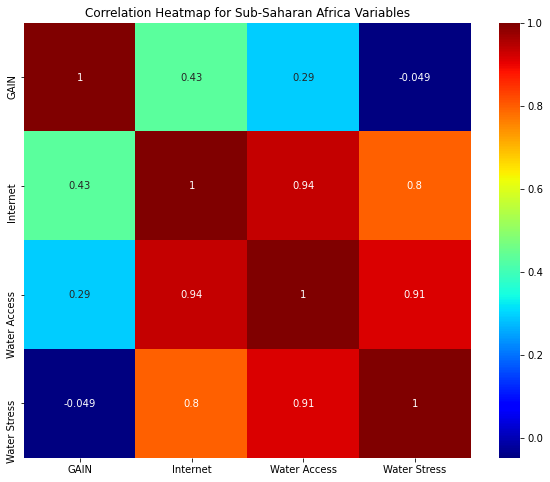

In [14]:
#Plot correlation heatmap for Sub-Saharan Africa

df_corr = pd.concat([df_corr_g['Sub-Saharan Africa'], df_corr_i['Sub-Saharan Africa'], 
                     df_corr_a['Sub-Saharan Africa'], df_corr_s['Sub-Saharan Africa']], axis = 1)

df_corr.columns.values[0] = 'GAIN'
df_corr.columns.values[1] = 'Internet'
df_corr.columns.values[2] = 'Water Access'
df_corr.columns.values[3] = 'Water Stress'

fig = plt.figure(figsize = (10,8))
plt.title('Correlation Heatmap for Sub-Saharan Africa Variables')
sb.heatmap(df_corr.corr(), cmap = 'jet', annot = True)

plt.show()

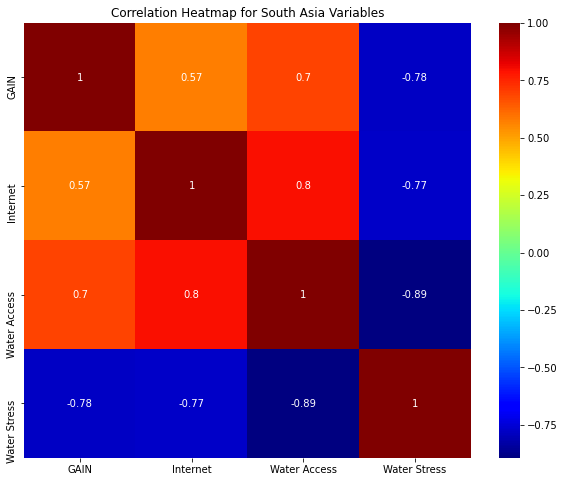

In [15]:
#Correlation heatmap for South Asia

df_corr = pd.concat([df_corr_g['South Asia'], df_corr_i['South Asia'], 
                     df_corr_a['South Asia'], df_corr_s['South Asia']], axis = 1)

df_corr.columns.values[0] = 'GAIN'
df_corr.columns.values[1] = 'Internet'
df_corr.columns.values[2] = 'Water Access'
df_corr.columns.values[3] = 'Water Stress'

fig = plt.figure(figsize = (10,8))
plt.title('Correlation Heatmap for South Asia Variables')
sb.heatmap(df_corr.corr(), cmap = 'jet', annot = True)

plt.show()

In [16]:
import geemap.eefolium as geemap
import ee

In [17]:
ee.Initialize()

In [18]:
#Map ofchange in maximum runoff month from 1993-1997 period to 2018-2022 period. This shows the risk from flash 
#flooding by focusing on extreme runoff values.

original = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('runoff')
            .filter(ee.Filter.date('1993-01-01', '1996-12-31'))
            .max())

current = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('runoff')
            .filter(ee.Filter.date('2018-01-01', '2021-12-31'))
                .max())

palette = ['#ff0000', '#ffa500', '#ffff00', '#00ff00', '#0000FF']

flood_change = (current.subtract(original)).divide(original).multiply(100)

the_map = geemap.Map()
the_map.add_basemap('HYBRID')
the_map.addLayer(flood_change.visualize(palette= palette, min=-200, max= 200), {}, 'Runoff Change- Flooding')

labels = ['-200%', '-100%', '0', '100%', '200%']

the_map.add_legend(title='Maximum Monthly Runoff Change', labels=labels, colors= palette)

the_map

## Next Steps:

1. Look into models that predict future extreme weather events (flooding) to estimate risk to least developed countries.
2. Obtain data on successful IoT sustainability projects that were able to monitor surface/ ground water and advance water sustainability to quantify potential impact.
3. Make a case to build IoT projects that help detect water flow anomalies and build infrastructure to capture more freshwater for people without access to potable water.

Below is an ARIMA ML timeseries model for Sub-Saharan Africa & South Asia. Not enough data to really build a useful model but it gives an idea of how dire the situation is for least developed countries.

In [19]:
#Before experimenting with timeseries modelling, we will explore the data to understand which model might be a good
#fit. Below is some statisical data about the trend in GAIN index for Sub-Saharan Africa.

from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_corr_g['Sub-Saharan Africa'].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -2.7028631126060985
ADF p-values: 0.07354413458304601
ADF number of lags used: 9
ADF number of observations: 16
ADF critical values: {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}
ADF best information criterion: 8.922285522512489


p is larger than 0.05, it is non-stationary

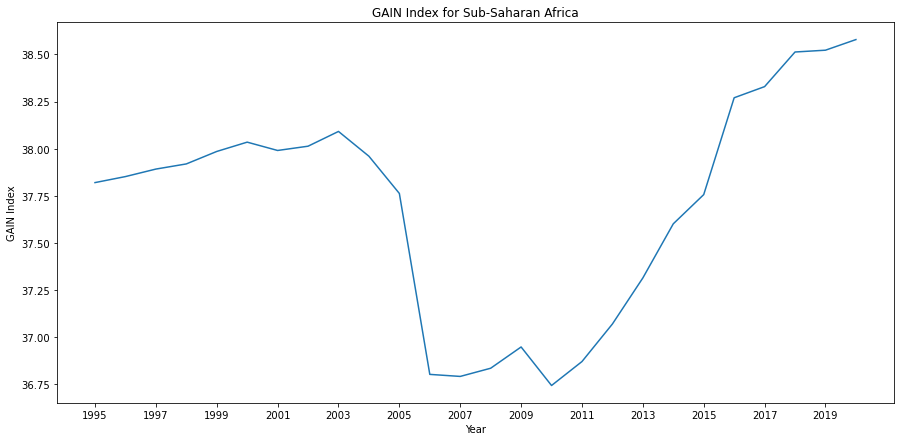

In [20]:
#Plot GAIN Index for Sub-Saharan Africa from 1995-2020

fig = plt.figure(figsize = (15,7))

df_corr_g['Sub-Saharan Africa'].plot()

plt.title('GAIN Index for Sub-Saharan Africa')
plt.xlabel('Year')
plt.ylabel('GAIN Index')
org = range(0,26, 2)
x_ticks = range(1995, 2021, 2)
plt.xticks(org, x_ticks)

plt.show()

In [21]:
#Training ARIMA model to predict future values, use auto_arima to choose appropriate values

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

train = df_corr_g['Sub-Saharan Africa'].values

smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         max_p=10, max_q=10, max_d=10,
                         m=1, start_P=0, start_Q = 0, 
                         seasonal=False, stationary = False,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16.401, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=264.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16.526, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8.309, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30.033, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8.311, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9.548, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7.353, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15.521, Time=0.09 sec
 ARIMA(2,0,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(2, 0, 3)   Log Likelihood                   4.030
Date:                Sat, 20 Aug 2022   AIC                              5.940
Time:                        17:26:34   BIC                             14.747
Sample:                             0   HQIC                             8.476
                                 - 26                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6096      4.345      0.831      0.406      -4.907      12.127
ar.L1          1.8406      0.169     10.861      0.000       1.508       2.173
ar.L2         -0.9366      0.124     -7.537      0.000      -1.180      -0.693
ma.L1         -1.0387      0.876     -1.186      0.236      -2.755       0.678
ma.L2          0.1432      0.950      0.151      0.880      -1.720       2.006
ma.L3          0.0406      0.666      0.061      0.951      -1.264       1.345
sigma2         0.0387      0.020      1.969      0.049       0.000       0.077
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               129.26
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -2.78
Prob(H) (two-sided):                  0.83   Kurtosis:                        12.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

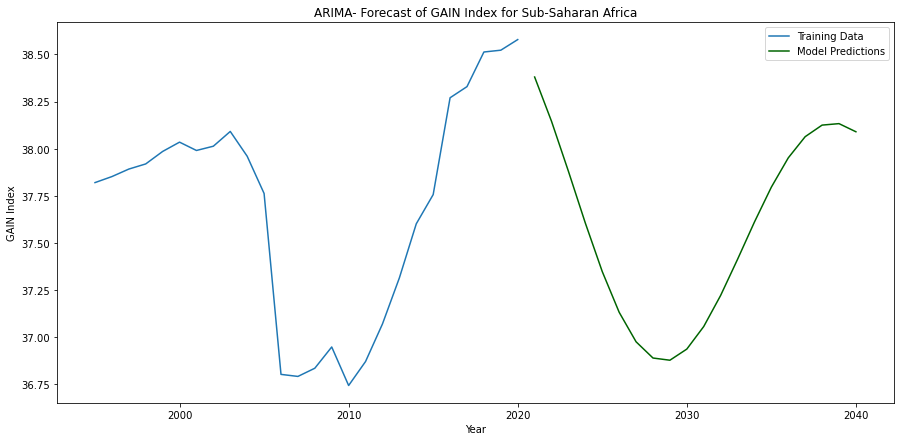

In [22]:
#Plotting timeseries prediction for next 20 years

n_periods = 20
fitted = smodel.predict(n_periods=n_periods)

index_train = range(1995, 2021)
index_pred = range(2021, 2021+n_periods)

#Make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_pred)
train_series = pd.Series(train, index=index_train)

# Plot
fig = plt.figure(figsize = (15,7))
plt.plot(train_series, label = 'Training Data')
#plt.plot(test, color = 'Orange', label = 'Test Data')
plt.plot(fitted_series, color='darkgreen', label = 'Model Predictions')
plt.legend()

plt.title('ARIMA- Forecast of GAIN Index for Sub-Saharan Africa')
plt.ylabel('GAIN Index')
plt.xlabel('Year')

plt.show()

In [23]:
#Before experimenting with timeseries modelling, we will explore the data to understand which model might be a good
#fit. Below is some statisical data about the trend in GAIN index for South ASia.

from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_corr_g['South Asia'].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.319941100350609
ADF p-values: 0.9226322080022595
ADF number of lags used: 8
ADF number of observations: 17
ADF critical values: {'1%': -3.889265672705068, '5%': -3.0543579727254224, '10%': -2.66698384083045}
ADF best information criterion: 30.926467931327345


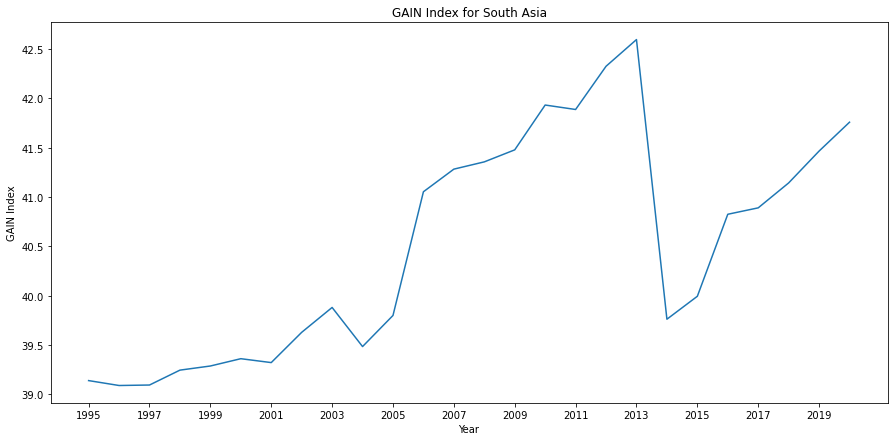

In [25]:
#Plot GAIN Index for South Asia from 1995-2020

fig = plt.figure(figsize = (15,7))

df_corr_g['South Asia'].plot()

plt.title('GAIN Index for South Asia')
plt.xlabel('Year')
plt.ylabel('GAIN Index')
org = range(0,26, 2)
x_ticks = range(1995, 2021, 2)
plt.xticks(org, x_ticks)

plt.show()

p is larger than 0.05, it is non-stationary

In [35]:
#Training ARIMA model to predict future values, use auto_arima to choose appropriate values

train = df_corr_g['South Asia'].values

amodel = pm.auto_arima(train, start_p=0, start_q=0, d = 2,
                         max_p=10, max_q=10, max_d=10,
                         m=1, start_P=0, start_Q = 0, 
                         seasonal=False, stationary = False,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

amodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=71.797, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=70.316, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=69.802, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.358 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -33.901
Date:                Sat, 20 Aug 2022   AIC                             69.802
Time:                        17:37:31   BIC                             70.980
Sample:                             0   HQIC                            70.114
                                 - 26                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9873      0.154      6.420      0.000       0.686       1.289
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                23.83
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              33.81   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

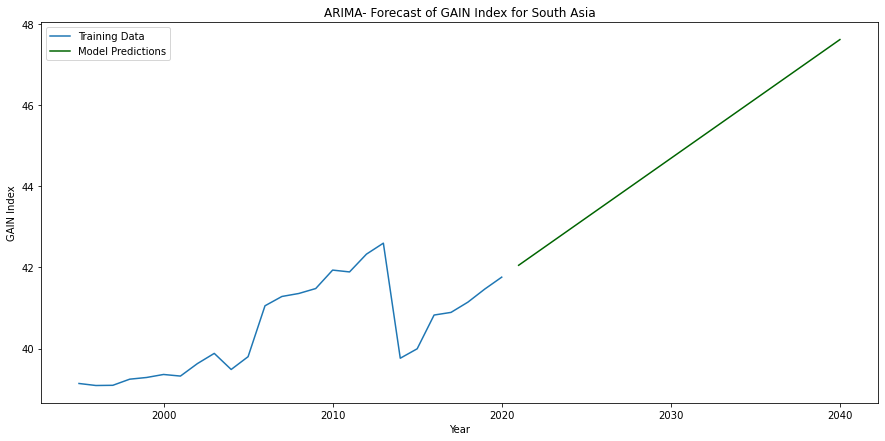

In [36]:
#Plotting timeseries prediction for next 20 years for South Asia

n_periods = 20
fitted = amodel.predict(n_periods=n_periods)

index_train = range(1995, 2021)
index_pred = range(2021, 2021+n_periods)

#Make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_pred)
train_series = pd.Series(train, index=index_train)

# Plot
fig = plt.figure(figsize = (15,7))
plt.plot(train_series, label = 'Training Data')
#plt.plot(test, color = 'Orange', label = 'Test Data')
plt.plot(fitted_series, color='darkgreen', label = 'Model Predictions')
plt.legend()

plt.title('ARIMA- Forecast of GAIN Index for South Asia')
plt.ylabel('GAIN Index')
plt.xlabel('Year')

plt.show()